# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034L,)
test label shape: (677L,)
dev label shape: (676L,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):
### STUDENT START ###
    # For every example in the training set (up to "num_examples")
    for i in range(num_examples):
        print '\tTHE TRAINING EXAMPLE:\n'
        # Print the training example
        print train_data[i]
        print
        # Print the corresponding label
            # Its name ("newsgroups_train.target_names") rather than its label (a number)
        print '\tIS LABELLED AS "{0}."\n'.format(newsgroups_train.target_names[train_labels[i]])
### STUDENT END ###
P1(2)

	THE TRAINING EXAMPLE:

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

	IS LABELLED AS "comp.graphics."

	THE TRAINING EXAMPLE:



Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corr

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [27]:
def P2():
### STUDENT START ###
    # a
    # a.1 - What is the size of the vocabulary?
    CV = CountVectorizer()
    feature_vectors = CV.fit_transform(raw_documents=train_data)
    print 'a) The size of the vocabulary is {0}.'.format(feature_vectors.shape[1])
    # That's the number of different words found in all the training examples.
    # Check that every feature appears at least once
    feature_vectors_array = feature_vectors.toarray()
    if len(np.nonzero(feature_vectors_array.sum(axis=0))[0]) != feature_vectors.shape[1]:
        print 'A column of zeros: At least one feature in the vocabulary does not appear in '\
              'the training set'

    # a.2 - What is the average number of non-zero features per example?
    print 'The average number of non-zero features per example is {0:.3f}.'.\
        format(feature_vectors.nnz / float(len(train_data)))
    # Since we've extracted the whole vocabulary, that's the average number of words per
        # example.
    # Another way to do that:
    len(np.nonzero(feature_vectors)[0]) / float(len(train_data))
    # A 3rd way to do that:
    nnz_feature = np.array([feature_vectors[i].nnz for i in range(len(train_data))])
    nnz_feature.mean()

    # a.3 - What fraction of the entries in the matrix are non-zero?
    print '{0:.3f}% of the entries in the matrix are non-zero.'.\
        format(100*float(feature_vectors.nnz) / (feature_vectors.shape[0] *
                                                 feature_vectors.shape[1]))


    # b
    # b.1 - What are the 0th and last feature strings (in alphabetical order)?
    # Hint: use the vectorizer's get_feature_names function.
    feature_strings = CV.get_feature_names()
    feature_strings.sort()
    print '\nb) The 0th (1st) feature string is "{0}"'.format(feature_strings[0])
    print 'The last feature string is "{0}"'.format(feature_strings[-1])


    # c
    # c.1 - Specify your own vocabulary with 4 words:
        # ["atheism", "graphics", "space", "religion"].
    # Confirm the training vectors are appropriately shaped.
    # Now what's the average number of non-zero features per example?
    ownvocab = ["atheism", "graphics", "space", "religion"]
    CV_ownvocab = CountVectorizer(vocabulary=ownvocab)
    feature_vectors_ownvocab = CV_ownvocab.transform(raw_documents=train_data)
    print '\nc) Dimensions of training vectors:', feature_vectors_ownvocab.shape
    print 'The average number of non-zero features per example, when using a 4-word ' \
          'vocabulary, is {0:.3f}.'.\
        format(feature_vectors_ownvocab.nnz / float(len(train_data)))
    # Since we've used a small (4-word vocabulary), any of the words in the vocabulary appears
         # in roughly 1 out of every 4 examples.
    # print '{0:.3f}% of the entries in the matrix are non-zero.'.\
    #     format(100*float(feature_vectors_ownvocab.nnz) / (feature_vectors_ownvocab.shape[0] *
    #                                                       feature_vectors_ownvocab.shape[1]))
    # Just to play...
    # nnz_feature = np.array([feature_vectors_ownvocab[i].nnz for i in range(len(train_data))])
    # nnz_feature.mean()
    # example_with_i_features = np.array([nnz_feature[nnz_feature==i].shape for i in
    #                                     range(len(ownvocab))])
    # print example_with_i_features
    # np.array([i*example_with_i_features[i] for i in
    #           range(len(ownvocab))]).sum() / float(feature_vectors_ownvocab.nnz)


    # d
    # d.1 - Instead of extracting unigram word features, use "analyzer" and "ngram_range" to
        # extract bigram and trigram character features.
    # What size vocabulary does this yield?
    CV_ngram = CountVectorizer(analyzer='char', ngram_range=(2,3))
    feature_vectors_ngram = CV_ngram.fit_transform(raw_documents=train_data)
    print '\nd) The size of the vocabulary when extracting bigram and trigram character ' \
          'features is {0}.'.format(feature_vectors_ngram.shape[1])

    CV_ngram_wb = CountVectorizer(analyzer='char_wb', ngram_range=(2,3))
    feature_vectors_ngram = CV_ngram_wb.fit_transform(raw_documents=train_data)
    print 'The size of the vocabulary when extracting bigram and trigram character features ' \
          'ONLY from text\n\tinside word boundaries is {0}.'.\
        format(feature_vectors_ngram.shape[1])
    # Had we extracted bigram and trigram word features the size of the vocabulary would be
        # 510583.
    # In that case, it becomes unlikely that features appear in more than one example, thus
        # increasing a lot the size of the vocabulary.
        # (It's kind of searching for a phrase instead of a word: more restrictive.)
    # When using n-gram character features, we add "redundancy"
        # (e.g., 'rel', 'eli', 'lig', igi', 'gio' and 'ion' become features for 'religion';
        # some of those features - especially the last ones, while the first may be more
        # characteristic of the word - may appear in many other words, and hence in many
        # other examples)
    # When using n-gram character features ONLY from text inside word boundaries we reduce
        # that "redundancy" a bit.


    # e
    # e.1 - Use the "min_df" argument to prune words that appear in fewer than 10 documents.
    # What size vocabulary does this yield?
    CV_prune = CountVectorizer(min_df=10)
    feature_vectors_prune = CV_prune.fit_transform(raw_documents=train_data)
    print '\ne) The size of the vocabulary when pruning words that appear in fewer than 10 ' \
          'documents is {0}.'.format(feature_vectors_prune.shape[1])


    # f
    # f.1 - Using the standard CountVectorizer,
        # what fraction of the words in the dev data are missing from the vocabulary?
    CV = CountVectorizer()
    print '\nf) {0:.2f}% of the words in the dev data are missing from the vocabulary ' \
          'based on the training data.'.\
        format(100*float(len(set(CV.fit(raw_documents=dev_data).get_feature_names()) -
                             set(CV.fit(raw_documents=train_data).get_feature_names()))) /
               len(set(CV.fit(raw_documents=dev_data).get_feature_names())))
    # Another way (that takes slightly more time to compute)
    # Both ways are based on the same idea:
        # words in dev set missing in training set = words in both sets - words in training set
    100*float(len(CV.fit(raw_documents=train_data+dev_data).get_feature_names()) -
              len(CV.fit(raw_documents=train_data).get_feature_names())) / len(
        CV.fit(raw_documents=dev_data).get_feature_names())
### STUDENT END ###
P2()

a) The size of the vocabulary is 26879.
The average number of non-zero features per example is 96.706.
0.360% of the entries in the matrix are non-zero.

b) The 0th (1st) feature string is "00"
The last feature string is "zyxel"

c) Dimensions of training vectors: (2034, 4)
The average number of non-zero features per example, when using a 4-word vocabulary, is 0.268.

d) The size of the vocabulary when extracting bigram and trigram character features is 35478.
The size of the vocabulary when extracting bigram and trigram character features ONLY from text
	inside word boundaries is 28954.

e) The size of the vocabulary when pruning words that appear in fewer than 10 documents is 3064.

f) 24.79% of the words in the dev data are missing from the vocabulary based on the training data.


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

k Nearest Neighbors:
--------------------
The optimal value for k is 96.
F1 score for a kNN classifier using the optimal value for k: 0.4336.

Multinomial Naive Bayes:
------------------------
The optimal value for alpha is 0.004.
F1 score for a Multinomial NB classifier using the optimal value for alpha: 0.7525.

Logistic Regression:
--------------------
The optimal value for C is 0.18.
F1 score for a Logistic Regression classifier using the optimal value for C: 0.6895.

|      |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|
------------------------------------------------------------------------------------
|  0.05|           14.0728|           13.6683|           14.6043|           11.8607|
|  0.10|           27.1297|           24.6589|           27.4595|           23.0213|
|  0.20|           49.7453|           42.7637|           49.3271|           42.6677|
|  0.30|           69.2984|           57.8665|           67.8944|           59.7623|
|  0.40|     

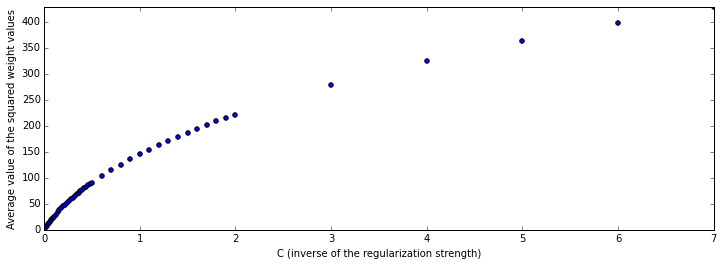

In [28]:
def P3():
### STUDENT START ###
    CV = CountVectorizer()
    feature_vectors_train = CV.fit_transform(raw_documents=train_data)
    feature_vectors_dev = CV.transform(raw_documents=dev_data)
    # For each of the 3 classifiers we'll use
        # GridSearchCV(classifier, param, scoring='f1_macro')
        # to find the optimal parameter associated with each classifier

    ######## kNN ########
    print 'k Nearest Neighbors:'
    print '--------------------'
    # Let's try values of k up to 200
    # A usual rule of thumb for selecting k is the square root of the size of the training set
        # (another proof that the optimal value of k is highly dependent on the training set
        # used)... but for text prediction I'm not sure if it would be
        # np.sqrt(feature_vectors_train.shape[0]) =  45.1 or
        # np.sqrt(feature_vectors_train.shape[1]) = 163.9
            # (probably the former but for text classification, unlike digit recognition in
            # last project, the number of features we work with is not fixed but depends on
            # the training set)
    param = {'n_neighbors': np.concatenate([np.arange(1,50,1),np.arange(50,100,2),
                                            np.arange(100,201,5)]).tolist()}
    # I started using GridSearch using every integer between 1 and 200 (199 possible values)
        # After finding out optimal k is 96, I used different steps (1, 2, or 5) to reduce
        # computation time
    best_param_kNN = GridSearchCV(KNeighborsClassifier(), param, scoring='f1_macro')
    best_param_kNN.fit(feature_vectors_train, train_labels)
    optimal_k = best_param_kNN.best_params_['n_neighbors']
    print 'The optimal value for k is {0}.'.format(optimal_k)
    # best_param_kNN.best_score_
    # best_param_kNN.grid_scores_
    kNN_model = KNeighborsClassifier(n_neighbors=optimal_k)
    kNN_model.fit(feature_vectors_train, train_labels)
    dev_predicted_labels = kNN_model.predict(feature_vectors_dev)
    print 'F1 score for a kNN classifier using the optimal value for k: {0:.4f}.'.\
        format(metrics.f1_score(y_true=dev_labels, y_pred=dev_predicted_labels,
                                average='macro'))

    ######## MultinomialNB ########
    print '\nMultinomial Naive Bayes:'
    print '------------------------'
    # Let's try values of alpha up to 1
    alpha = np.concatenate([np.arange(0,0.01,0.002),np.arange(0.01,0.1,0.01),
                            np.arange(0.1,1.1,0.1)])
    # Again, I started using GridSearch using step=0.002 between 0 and 1 (501 possible values)
        # After finding out optimal alpha is 0.004, I used different steps to reduce
        # computation time
    param = {'alpha': list(alpha)}
    best_param_NB = GridSearchCV(MultinomialNB(), param, scoring='f1_macro')
    best_param_NB.fit(feature_vectors_train, train_labels)
    optimal_alpha = best_param_NB.best_params_['alpha']
    print 'The optimal value for alpha is {0}.'.format(optimal_alpha)
    # best_param_NB.best_score_
    NB_model = MultinomialNB(alpha=optimal_alpha)
    NB_model.fit(feature_vectors_train, train_labels)
    dev_predicted_labels = NB_model.predict(feature_vectors_dev)
    print 'F1 score for a Multinomial NB classifier using the optimal value for alpha: ' \
          '{0:.4f}.'.format(metrics.f1_score(y_true=dev_labels, y_pred=dev_predicted_labels,
                                             average='macro'))

    ######## Logistic Regression ########
    print '\nLogistic Regression:'
    print '--------------------'
    # According to documentation, C is the "inverse of regularization strength.
        # Like in SVMs, smaller values specify stronger regularization."
    inv_regul_str = np.concatenate([np.arange(0.01,0.1,0.01),np.arange(0.1,0.5,0.02),
                                    np.arange(0.5,2,0.1),np.arange(2,8,1)])
    # Again, I started using GridSearch using step=0.01 between 0 and 2 (200 possible values)
        # After finding out optimal C is 0.18, I used different steps to reduce computation
        # time
    param = {'C': list(inv_regul_str)}
    best_param_Logit = GridSearchCV(LogisticRegression(penalty='l2'), param,
                                    scoring='f1_macro')
    best_param_Logit.fit(feature_vectors_train, train_labels)
    optimal_C = best_param_Logit.best_params_['C']
    print 'The optimal value for C is {0}.'.format(optimal_C)
    Logit_model = LogisticRegression(penalty='l2', C=optimal_C)
    Logit_model.fit(feature_vectors_train, train_labels)
    dev_predicted_labels = Logit_model.predict(feature_vectors_dev)
    print 'F1 score for a Logistic Regression classifier using the optimal value for C: ' \
          '{0:.4f}.'.format(metrics.f1_score(y_true=dev_labels, y_pred=dev_predicted_labels,
                                             average='macro'))

    # Output the sum of the squared weight values for each class
        # for each setting of the C parameter.
    squared_sum = np.zeros(4*inv_regul_str.shape[0]).reshape(inv_regul_str.shape[0],4)
    for i,c in enumerate(inv_regul_str):
        Logit_model = LogisticRegression(penalty='l2', C=c)
        Logit_model.fit(feature_vectors_train, train_labels)
        squared_sum[i,:] = np.square(Logit_model.coef_).sum(axis=1)
    # To make it shorter, just print 10 intermediate values
        # (i.e., 10*4 points instead of 50*4; 50 will be plotted later)
    squared_sum_short = squared_sum[4::5,:]
    inv_regul_str_short = inv_regul_str[4::5]
    classes = [c.rjust(18) for c in newsgroups_train.target_names]
    print "\n|      |{}|{}|{}|{}|".format(*classes)
    print '----------------------------------------------' \
          '--------------------------------------'
    table = []
    for i in range(10):
        table.append([inv_regul_str_short[i], squared_sum_short[i,0], squared_sum_short [i,1],
                      squared_sum_short [i,2], squared_sum_short [i,3]])
    for i in table:
        print "|{:6.2f}|{:18.4f}|{:18.4f}|{:18.4f}|{:18.4f}|".format(*i)

    # Another way of plotting the table, using matplotlib
    # plt.figure(figsize=(10, 10))
    # ax = plt.gca()
    # ax.axes.get_xaxis().set_visible(False)
    # ax.axes.get_yaxis().set_visible(False)
    # ax.axis('off')
    # table2 = plt.table(cellText=np.around(squared_sum_short, decimals=4),
    #                    rowLabels=inv_regul_str_short,
    #                    colLabels=newsgroups_train.target_names, loc='center')
    # plt.show()

    # Since the sum of the squared weight values is quite similar for each class, let's
        # compare its average value (considering the 4 classes) to C, for each value of C
    squared_sum_mean = squared_sum[:,1:].mean(axis=1)
    plt.figure(figsize=(12, 4))
    plt.scatter(inv_regul_str, squared_sum_mean)
    plt.xlabel("C (inverse of the regularization strength)")
    plt.ylabel("Average value of the squared weight values")
    plt.ylim([0, squared_sum_mean.max()])
    plt.xlim([0, inv_regul_str.max()])
### STUDENT END ###
P3()

ANSWER:

a. Why doesn't nearest neighbors work well for this problem?

**kNN models are based on metrics of proximity/similartiy, based on features of the items (which acts as coordinates or dimensions). In topic classification the challenge is that the number of features that define the space (be them words or character n-grams) are almost infinite, but we train our model with a very limited number of features: the ones that are present in the examples from the training set. Thus, we are omitting many other dimensions, (in other classification problems we limit our knowledge to a hyperplane in the feature space—like a square in a plane—; here we are limited to a plane in a cube, so to speak).**

**But I think that the main problem is that we are assigning the same weight to all the features in the training set. There will be lots of common words shared by all the training examples, as well as the example that we want to predict, that will lead to similar distances between that example that we want to predict and any pair of training examples, regardless of their topics, that will cause many predictions to be inaccurate. The solution would be to give more weight to topic-related words, and less to common words (shared by examples from every topic).**

**To continue with a simplified example, think of a 3-D space where *x=graphics*, *y=religion*, *z=common words*: if a graphics' training example has coordinates $(2,0,18)$, and a religion's training example has coordinates $(0,2,20)$, a dev example related to graphics, with coordinates $(1,0,20)$ would be equally close ($\sqrt 5$) to the training examples.**

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

**In general, NB (a generative model) has greater bias but lower variance than Logistic Regression (a discriminative model). Both lower bias and higher variance are needed to get better predictions: bias (which is related to underfitting) is what causes error rate in both the training set and the dev set to be high (and roughly equal); variance (which is related to overfitting) is what causes the error rate in the dev set to increase while the error rate in the training set keeps decreasing, and hence it's a problem when the model is too complex, given a fixed dataset size.**

**Bias appears in NB models when NB assumptions are not met (mainly, the conditional independence assumption, that states that the features are independent of each other given the class; e.g., given that a document is about *space*, "*launch*" and "*spacecraft*" are independent of each other). (Some sources mention that, provided the NB assumptions hold, NB and Logistic Regression and Naive Bayes perform almost identically as the number of training examples approaches infinity.)**

**The fact that Logistic Regression doesn't work as well as NB suggests that the bias of the latter is not as large as the higher variance of Logistic Regression. I.e., it seems that the conditional independence assumption holds, even though that doesn't seem correct in text classification (words are highly dependent of each other). The truth is that the assumption is broken, but that's not a big deal—of course, the probability estimates will be inaccurate, but it's how they compare to each other what we care about (i.e., which class gets the highest score), so the decisions will be good.**

**To put an example, let's remember that:**

**$$P(\text{class} \mid \text{features}) = \frac{P(\text{features} \mid \text{class}) \cdot P(\text{class})}{\sum_{\forall \text{class}} P(\text{features} \mid \text{class}) \cdot P(class)}$$**

**Suppose the dev example we want to classify has a set of features $f$: most of the features are typical in *atheism* but not in the other topics. To simplify the example, let's assume the only other topic is *graphics*. That means that $P(f \mid \text{atheism})$ will be much greater than $P(f \mid \text{graphics})$, causing $P(\text{atheism} \mid f)$ to be much greater than $P(\text{graphics} \mid f)$. These two probability estimates will be inaccurate (in many cases, the former will be close to 1 and the latter close to 0), but what matters—when it makes to classifying—is not what their values are, but simply that $P(\text{atheism} \mid f) > P(\text{graphics} \mid f)$.**

**On the other hand, variance is a problem in Logistic Regression because the model is *too complex*. We can approximate the complexity as the ratio of features and training examples: we have so many features, compared to the number of training examples, that variance becomes a problem and makes Logistic Regression perform worse than NB. If we had more training examples (although that might involve more features too, in text classification), Logistic Regression would perform better than Naive Bayes (that works better with less training data, as the estimates are based on joint probabilities).**

c. Briefly explain the relationship between the sum and the value of C.

**As shown in the plot above, it looks like the relationship between the sum—its average value for the 4 classes has been plotted, but the graph would not look very different for each particular class—and the value of C can be approximated as $k \cdot C^{\alpha}$, where $k$ and $\alpha$ are constants, with $\alpha < 1$.**

**This is coherent with the fact that *smaller values (of C) specify stronger regularization*, so as C approaches zero, all the coefficients (for any class) also approach zero, resulting in:**

**$$P(Y \mid \theta) = \frac{1}{1+e^{-\theta}} \rightarrow \frac{1}{1+e^0} = \frac{1}{2}$$**

**I.e., as expected a very strong regularization leads to the null model, in which we are uncertain about the category and assign a 50% likelihood to any of them (the classification may be seem as random). On the other hand, as we penalize less and less (the complexity of the model), the sum of the squared weight values increases, and so do the relevance of the features. But it is important to note that it's the *absolute* values (because we are squaring them) which increase: the features that are common in a topic will have positive values, leading to an increase in the likelihood of belonging to that topic if the example we want to classify have those features; on the other hand, features that are not so common in a given topic may be great in absolute value, but will be negative, thus decreasing an example's likelihood of belonging to that topic if that example have those features.**

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?


|              |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|
--------------------------------------------------------------------------------------------
|bobby         |            0.5971|           -0.1463|           -0.2088|           -0.2828|
|atheism       |            0.5963|           -0.2583|           -0.2556|           -0.3056|
|religion      |            0.5960|           -0.3682|           -0.4829|           -0.0159|
|atheists      |            0.5824|           -0.0860|           -0.1955|           -0.3994|
|islam         |            0.5122|           -0.0929|           -0.2053|           -0.2069|
|graphics      |           -0.4885|            1.2159|           -0.8004|           -0.4551|
|image         |           -0.3291|            0.8024|           -0.4680|           -0.2697|
|file          |           -0.2079|            0.7816|           -0.5118|           -0.3589|
|3d            |           -0.2241|            0.6848|           -0.3

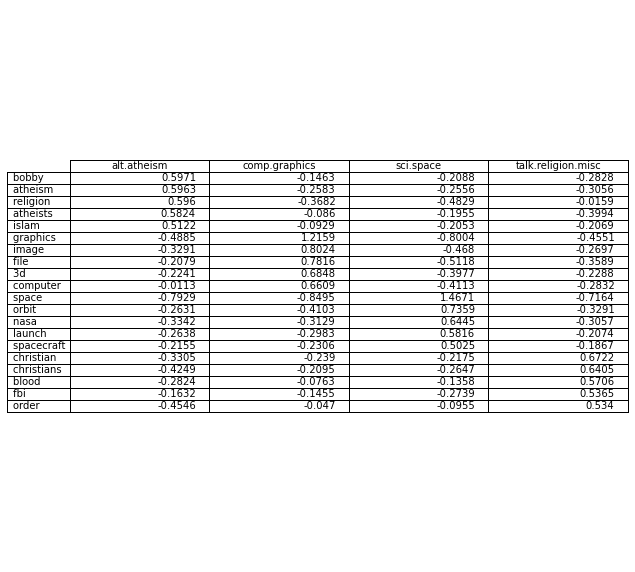


|              |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|
--------------------------------------------------------------------------------------------
|cheers kent   |            0.4027|           -0.4748|           -0.4585|            0.4105|
|claim that    |            0.3844|           -0.1318|           -0.1820|           -0.0792|
|in this       |            0.3525|           -0.0131|           -0.3595|           -0.0824|
|is not        |            0.3448|           -0.1728|           -0.3370|            0.0337|
|are you       |            0.3389|           -0.1795|           -0.0845|           -0.1998|
|looking for   |           -0.4674|            0.8202|           -0.3604|           -0.4093|
|in advance    |           -0.3440|            0.6334|           -0.3187|           -0.3041|
|out there     |           -0.2094|            0.5660|           -0.3448|           -0.2027|
|is there      |           -0.2304|            0.5314|           -0.3

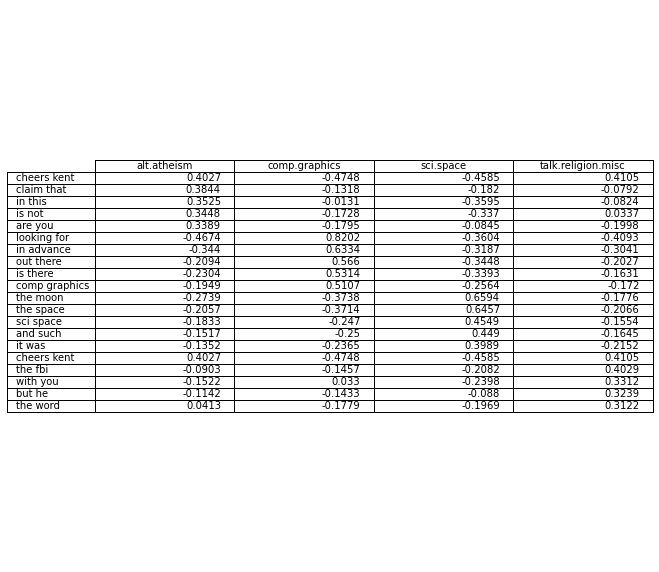

In [13]:
def P4():
### STUDENT START ###
    def create_table(CV):
        feature_vectors = CV.fit_transform(raw_documents=train_data)
        # Note that I use the optimal value of C previously found
        Logit_model = LogisticRegression(penalty='l2', C = 0.18)
        Logit_model.fit(feature_vectors, train_labels)
        # Now that we have the weights for each label, let's find what the 5 features with
            # the largest ones are, for each label
        ind = np.argpartition(Logit_model.coef_, -5)[:,-5:]
        # We have the positions of the 5 features with the largest weights, but unordered
        ind = np.argpartition(Logit_model.coef_, -5)[:,-5:]
        for i in range(len(newsgroups_train.target_names)):
            ind[i,:] = ind[i, np.argsort(np.take(Logit_model.coef_[i,:], ind[i,:]))[::-1]]
        # Now that they're ordered (from largest to smallest), let's prepare them to get the
            # weights in those positions
        ind = ind.flatten()
        weights = np.take(Logit_model.coef_, ind, axis=1).T
        word_features = CV.get_feature_names()
        # Print the table
        main_features = np.empty(20).astype('str')
        print
        for i in range(ind.shape[0]):
            main_features[i] = word_features[ind[i]].ljust(14)
        classes = [c.rjust(18) for c in newsgroups_train.target_names]
        print "|              |{}|{}|{}|{}|".format(*classes)
        print '------------------------------------------------------' \
              '--------------------------------------'
        table = []
        for i in range(20):
            f = main_features[i]
            table.append([f, weights[i,0], weights[i,1], weights[i,2], weights[i,3]])
        for i in table:
            print "|{}|{:18.4f}|{:18.4f}|{:18.4f}|{:18.4f}|".format(*i)
        print

        # Another way of plotting the table, using matplotlib
        plt.figure(figsize=(10, 10))
        ax = plt.gca()
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.axis('off')
        table2 = plt.table(cellText=np.around(weights, decimals=4),rowLabels=main_features, 
                           colLabels=newsgroups_train.target_names,loc='center')
        plt.show()

    create_table(CountVectorizer())
    create_table(CountVectorizer(analyzer='word', ngram_range=(2,2)))
### STUDENT END ###
P4()

ANSWER: **The 2 tables look rather different, but that's not surprising at all.**

**When we use words, the model makes a relatively good work finding the ones that are most frequent in a topic and less in the others. Hence, we see that the weight values for those *top 5* features have a relatively large positive value for the corresponding class (e.g., 0.66 for "*computer*" associated with *graphics*), and a large absolute value, but negative, for the other classes (e.g., see the weights of "*computer*" for the other 3 classes; it's only close to 0 for *atheism*; also note that the same happens with the word "*religion*:" 0.59 for *atheism*, -0.26 for both *graphics* and *space*, and close to 0 for *religion*). I.e., the presence of those features increase significantly the likelihood of being part of that class, and also the likelihood of not being part of the others.**

**When we use bigrams, it is unrare that two words associated with one topic—and not the others—appear together (e.g., "*nasa orbit*" or "*computer 3d*"). Exceptions are "*the moon*" or "*the space*," and do note that their weight values are large for *space* and large in absolute value but negative for the other 3 classes. In general, typical bigrams are like the ones that are shown in the 2nd table: "*in this*," "*out there*," or "*and such*." They are not exclusive of a certain topic, and hence it's not so unlikely to find some in training examples of other topics: that causes that the weight values, when positive, are not so great (most of them are between 0.3 and 0.5 instead of between 0.5 and 0.8, as it occurred in the 1st table), and when they are negative (i.e., the weight values for a bigram when inspecting the likelihood of a different class), they are also not great in absolute value. Exceptions are "*the moon*" or "*the space*," as mentioned, but look for example at "*the fbi*" or "*the word*."**

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [32]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
    # Lowercase characters (though CountVectorizer does it by default, this improves F1)
    s = s.lower()
    # Discard non-letter or non-number characters
    s = re.sub("[^A-Za-z0-9 \\n]", " ", s)
    # Shorten long words to no more than 6 characters
        # I also tried 8, 7, 5... Some work better when we don't make other transformations
            # but with all of these combined, 6 is the one that yields a higher F1 score
        # It is worth mentioning that 5 improves F1 by almost the same (3.1 points instead of
            # 3.2), and reduces the dictionary size much more (to 42%).
    s = re.sub("(\w{%d})\w+" % 6, "\\1", s)
    # Replace sequences of numbers with " number " (a single token)
    s = re.sub("([\d]+)", " number ", s)
    return s
### STUDENT END ###

def P5():
### STUDENT START ###
    # Define a function to use with both preprocessors
    def preprocessor_results(CV):
        feature_vectors_train = CV.fit_transform(raw_documents=train_data)
        feature_vectors_dev = CV.transform(raw_documents=dev_data)
        Logit_model = LogisticRegression(penalty='l2')
        # Note that I no longer use the value of C previously found (not optimal anymore)
            # but the default value
        Logit_model.fit(feature_vectors_train, train_labels)
        dev_predicted_labels = Logit_model.predict(feature_vectors_dev)
        # Return the size of the dictionary for further comparison, as well as the F1 score
        return [feature_vectors_train.shape[1], metrics.f1_score(y_true=dev_labels,
                                                                 y_pred=dev_predicted_labels,
                                                                 average='macro')]

    # And then call that function using each preprocessor
    [size_empty, F1_empty] = preprocessor_results(CountVectorizer(preprocessor =
                                                                  empty_preprocessor))
    print 'F1 score for a Logistic Regression classifier using empty_preprocessor: {0:.4f}'.\
        format(F1_empty)
    # Please note that empty preprocessor makes some preprocessing.
        # That's why the F1 score is slightly lower than what we obtained in P3.
    [size_better, F1_better] = preprocessor_results(CountVectorizer(preprocessor =
                                                                    better_preprocessor,
                                                                    stop_words='english'))
    # Though not included in the function better_preprocessor, I add "stop_words='english'"
        # in this case, which also increases F1.
        # (I also tried strip_accents=‘ascii’ and strip_accents='unicode' but that doesn't 
            # seem to have any effect)
    print 'F1 score for a Logistic Regression classifier using better_preprocessor: ' \
          '{0:.4f}\n\t({1:.1f} points higher)'.format(F1_better, 100.*(F1_better-F1_empty))
    print 'The size of the dictionary with better_preprocessor is {0:.1f}% of the size of\n' \
          '\tthe dictionary with empty_preprocessor.'.format(100*float(size_better)/size_empty)
### STUDENT END ###
P5()

F1 score for a Logistic Regression classifier using empty_preprocessor: 0.6871
F1 score for a Logistic Regression classifier using better_preprocessor: 0.7194
	(3.2 points higher)
The size of the dictionary with better_preprocessor is 51.7% of the size of
	the dictionary with empty_preprocessor.


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

* Number of learned weights not equal to zero using a "l2" penalty: 107516
* These weights correspond to a total of 26879 features (vocabulary size)

C = 0.001
---------
* Number of learned weights not equal to zero using a "l1" penalty: 5
	(0.0% of the number using "l2")
* These weights correspond to a total of 2 features (vocabulary size)
	(0.0% of the size using "l2")
* Accuracy using a "l2" penalty without pruning: 0.6346
* Accuracy using a "l2" penalty after pruning:   0.3417 (46.15% lower)

C = 0.01
---------
* Number of learned weights not equal to zero using a "l1" penalty: 34
	(0.0% of the number using "l2")
* These weights correspond to a total of 16 features (vocabulary size)
	(0.1% of the size using "l2")
* Accuracy using a "l2" penalty without pruning: 0.6805
* Accuracy using a "l2" penalty after pruning:   0.4749 (30.22% lower)

C = 0.1
---------
* Number of learned weights not equal to zero using a "l1" penalty: 359
	(0.3% of the number using "l2")
* These weights corres

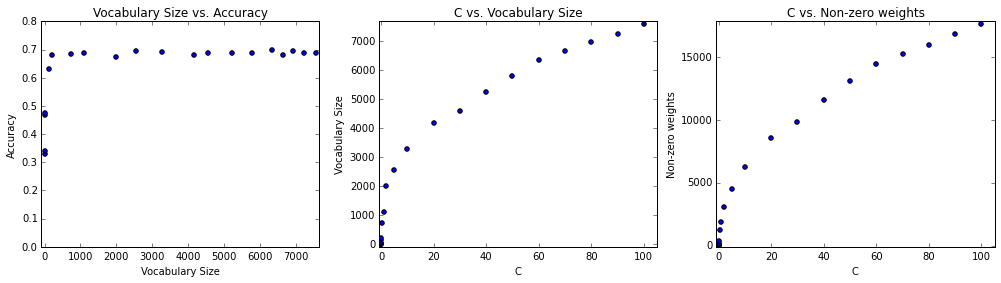

In [7]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    # We'll plot results for several values of C
    c = np.concatenate([np.array([0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5]),
                        np.linspace(10,100,10)])
    accuracy = np.zeros(len(c))
    vocab_size = np.zeros(len(c)).astype('u4')
    nonzero_weights = np.zeros(len(c)).astype('u4')
    for i in range(len(c)):
        CV = CountVectorizer()
        feature_vectors_train = CV.fit_transform(raw_documents=train_data)
        feature_vectors_dev = CV.transform(raw_documents=dev_data)
        # Train a logistic regression model using a "l1" penalty.
        Logit_model_l1 = LogisticRegression(penalty='l1', C = c[i], tol=.01)
        Logit_model_l1.fit(feature_vectors_train, train_labels)

        vocab_size[i] = np.count_nonzero(np.apply_along_axis(np.count_nonzero, 0,
                                                             Logit_model_l1.coef_))
        nonzero_weights[i] = np.apply_along_axis(np.count_nonzero, 0,
                                                 Logit_model_l1.coef_).sum()
        # nonzero_weights is greater than vocab_size because some features may have a
            # non-zero weight in more than one class.
        # To know the number of non-zero weights per class we would just have to do:
        # np.apply_along_axis(np.count_nonzero, 1, Logit_model_l1.coef_)

        # We want to reduce the size of the vocabulary by keeping only those features that
            # have at least one non-zero weight and retrain a model using "l2".
        # To do that, we filter those weights/coefficients that are not equal to zero.
        mask = (Logit_model_l1.coef_!=0)
        # Any column (i.e., feature) with at least one non-zero weight (that is, for at least
            # one class) must be kept
        idx = mask.any(axis=0)
        # We prune both sparse matrices: train (to retrain the model) and dev set (to see how
            # the new model predicts compared to the non-pruned one)
        feature_vectors_train_pruned = feature_vectors_train[:, idx]
        feature_vectors_dev_pruned = feature_vectors_dev[:, idx]
        # Another way to calculate the size of the vocabulary would be:
        # vocab_size[i] = feature_vectors_train_pruned.shape[1]

        # We define the logistic model using "l2"
        Logit_model_l2 = LogisticRegression(penalty='l2', C = c[i], tol=.01)
        # And fit it only with the features given by "l1"
        Logit_model_l2.fit(feature_vectors_train_pruned, train_labels)
        dev_predicted_labels_pruned = Logit_model_l2.predict(feature_vectors_dev_pruned)
        accuracy[i] = metrics.accuracy_score(y_true=dev_labels,
                                             y_pred=dev_predicted_labels_pruned)

        # Print main results for selected values of C
        if c[i] in [0.001, 0.01, 0.1, 1, 10, 100]:
            Logit_model_l2.fit(feature_vectors_train, train_labels)
            l2_nonzero_weights = np.apply_along_axis(np.count_nonzero, 0,
                                                     Logit_model_l2.coef_).sum()
            l2_vocab_size = np.count_nonzero(np.apply_along_axis(np.count_nonzero, 0,
                                                                 Logit_model_l2.coef_))
            if c[i]==0.001:
                # No need to print it for every possible C (always the same values)
                print '* Number of learned weights not equal to zero using a "l2" penalty: ' \
                      '{0}'.format(l2_nonzero_weights)
                print '* These weights correspond to a total of {0} features (vocabulary ' \
                      'size)\n'.format(l2_vocab_size)
            # As expected, none of the features has a non-zero weight using "l2".
            # That's why the latter value is the total number of features and the former
                # value is 4 (the number of classes) times the latter.
            print 'C = {0}'.format(c[i])
            print '---------'
            print '* Number of learned weights not equal to zero using a "l1" penalty: {0}' \
                  '\n\t({1:.1f}% of the number using "l2")'.\
                format(nonzero_weights[i], round(100.*nonzero_weights[i]/l2_nonzero_weights,2))
            print '* These weights correspond to a total of {0} features (vocabulary size)' \
                  '\n\t({1:.1f}% of the size using "l2")'.\
                format(vocab_size[i], round(100.*vocab_size[i]/l2_vocab_size,2))
            dev_predicted_labels_unpruned = Logit_model_l2.predict(feature_vectors_dev)
            accuracy_unpruned = metrics.accuracy_score(y_true=dev_labels,
                                                       y_pred=dev_predicted_labels_unpruned)
            print '* Accuracy using a "l2" penalty without pruning: {0:.4f}'.\
                format(accuracy_unpruned)
            print '* Accuracy using a "l2" penalty after pruning:   {0:.4f} ({1:.2f}% lower)' \
                  '\n'.format(accuracy[i], round(100*(1-accuracy[i]/accuracy_unpruned),2))
            # As the output will show, the accuracy after pruning is reduced for small values
                # of C (which correspond to a regularization that strongly penalizes
                # additional features), and then (from C=0.1 on) it becomes roughly the same
                # than the accuracy without pruning, being equal to it when C=100 (even though
                # the number of features has still been reduced to roughly the 25%)

    # Plot the accuracy of the re-trained model vs. the vocabulary size when pruning unused
        # features by adjusting the C parameter.
    plt.figure(figsize=(14, 4))
    ax = plt.subplot(1, 3, 1)
    plt.scatter(vocab_size, accuracy)
    plt.xlabel("Vocabulary Size")
    plt.ylabel("Accuracy")
    plt.title('Vocabulary Size vs. Accuracy')
    plt.xlim([-100, vocab_size.max()+100])
    plt.ylim([0, 0.8])
    # Also plot other relationships of interest
    ax = plt.subplot(1, 3, 2)
    plt.scatter(c, vocab_size)
    plt.xlabel("C")
    plt.ylabel("Vocabulary Size")
    plt.title('C vs. Vocabulary Size')
    plt.xlim([-1, c.max()+5])
    plt.ylim([-100, vocab_size.max()+100])
    ax = plt.subplot(1, 3, 3)
    plt.scatter(c, nonzero_weights)
    plt.xlabel("C")
    plt.ylabel("Non-zero weights")
    plt.title('C vs. Non-zero weights')
    plt.xlim([-1, c.max()+5])
    plt.ylim([-100, nonzero_weights.max()+200])
    plt.tight_layout()
    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Accuracy for a Logistic Regression classifier using TfidfVectorizer: 76.33%
Percentage of incorrectly predicted labels (R>1): 23.67% (=1-Accuracy)

--------------------------------------------------------
216th DOCUMENT: R = 929.36
* PREDICTED CATEGORY (prob = 0.9937): comp.graphics
* CORRECT CATEGORY   (prob = 0.0011): talk.religion.misc

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but

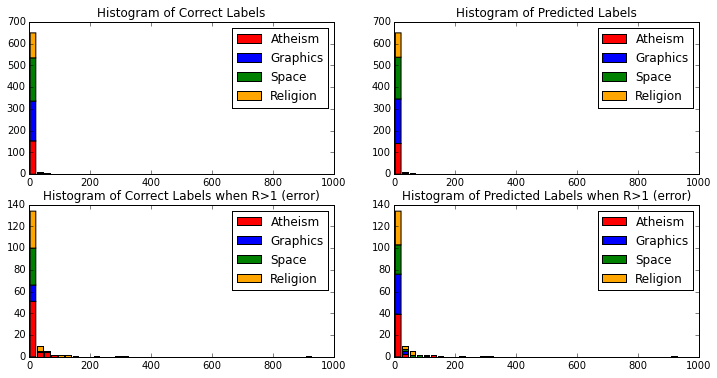

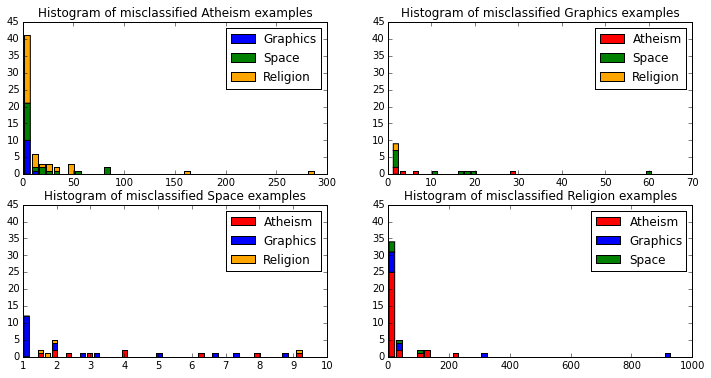

In [17]:
def P7():
### STUDENT START ###
    TFIDF = TfidfVectorizer()
    feature_vectors_train = TFIDF.fit_transform(raw_documents=train_data)
    Logit_model = LogisticRegression(penalty='l2', C = 100)
    Logit_model.fit(feature_vectors_train, train_labels)
    feature_vectors_dev = TFIDF.transform(raw_documents=dev_data)
    dev_predicted_labels = Logit_model.predict(feature_vectors_dev)
    print 'Accuracy for a Logistic Regression classifier using TfidfVectorizer: {0:.2f}%'.\
        format(100*metrics.accuracy_score(y_true=dev_labels, y_pred=dev_predicted_labels))
    dev_Probs = Logit_model.predict_proba(feature_vectors_dev)
    # maximum predicted probability
    max_Prob = dev_Probs.max(axis=1)
    # predicted probability of the correct label
    Prob_correct_label = np.array([dev_Probs[i,j] for i,j in
                                   zip(range(len(dev_labels)),dev_labels)])
    # R = maximum predicted probability / predicted probability of the correct label
    R = max_Prob / Prob_correct_label
    print 'Percentage of incorrectly predicted labels (R>1): {0:.2f}% (=1-Accuracy)\n'.\
        format(100*len(R[R>1])/float(len(R)))
    # Top 3
    doc_index = np.argpartition(R, -3)[-3:]
    # Top 3 in descending order
    doc_index = doc_index[np.argsort(R[doc_index])][::-1]
    for i,ind in enumerate(doc_index):
        print '--------------------------------------------------------'
        print '{0}th DOCUMENT: R = {1:.2f}'.format(ind+1, R[ind])
        print '* PREDICTED CATEGORY (prob = {0:.4f}): {1}'.\
            format(max_Prob[ind],
                   newsgroups_train.target_names[dev_Probs[ind,:].argmax()])
        print '* CORRECT CATEGORY   (prob = {0:.4f}): {1}\n'.\
            format(dev_Probs[ind,dev_labels[ind]],
                   newsgroups_train.target_names[dev_labels[ind]])
        print dev_data[ind]

    # Plot histograms of labels (correct and predicted)
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(2, 2, 1)
    atheism = R[(dev_labels==0)]
    graphics = R[(dev_labels==1)]
    space = R[(dev_labels==2)]
    religion = R[(dev_labels==3)]
    plt.hist([atheism,graphics,space,religion], 40, stacked=True, color=['red','blue','green','orange'])
    plt.legend(['Atheism','Graphics','Space','Religion'])
    plt.title('Histogram of Correct Labels')
    ax = plt.subplot(2, 2, 2)
    pred_atheism = R[(dev_predicted_labels==0)]
    pred_graphics = R[(dev_predicted_labels==1)]
    pred_space = R[(dev_predicted_labels==2)]
    pred_religion = R[(dev_predicted_labels==3)]
    plt.hist([pred_atheism,pred_graphics,pred_space,pred_religion], 40,
             stacked=True, color=['red','blue','green','orange'])
    plt.legend(['Atheism','Graphics','Space','Religion'])
    plt.title('Histogram of Predicted Labels')
    # The first two graphs (top row) show all the examples in the dev set
    # The first bar in both graphs show examples with R=1, i.e., correctly classified so the proportion of each
        # category is the same in both graphs (due to the bin width, some examples with an R ratio greater than 1
        # are also included in that first bar, so there may be some minor differences between both graphs)
    # To zoom in what really happens when R>1 (i.e., when the prediction is not correct) we plot (in the bottom row)
        # the histogram for R>1.
    ax = plt.subplot(2, 2, 3)
    atheism = R[(dev_labels==0) & (R>1)]
    graphics = R[(dev_labels==1) & (R>1)]
    space = R[(dev_labels==2) & (R>1)]
    religion = R[(dev_labels==3) & (R>1)]
    plt.hist([atheism,graphics,space,religion], 40, stacked=True, color=['red','blue','green','orange'])
    plt.legend(['Atheism','Graphics','Space','Religion'])
    plt.title('Histogram of Correct Labels when R>1 (error)')
    ax = plt.subplot(2, 2, 4)
    pred_atheism = R[(dev_predicted_labels==0) & (R>1)]
    pred_graphics = R[(dev_predicted_labels==1) & (R>1)]
    pred_space = R[(dev_predicted_labels==2) & (R>1)]
    pred_religion = R[(dev_predicted_labels==3) & (R>1)]
    plt.hist([pred_atheism,pred_graphics,pred_space,pred_religion], 40,
             stacked=True, color=['red','blue','green','orange'])
    plt.legend(['Atheism','Graphics','Space','Religion'])
    plt.title('Histogram of Predicted Labels when R>1 (error)')
    # We can see that classifying an 'Atheism' example as another topic happens much more frequently than the opposite
        # (classifying another topic as 'Atheism'). The same happens with 'Space'.
    # On the other hand, there are fewer examples of 'Graphics' classified as another topic than examples of other
        # topics classified as 'Graphics'.
        
    # To see what are the most common mistakes, we now plot the proportion of misclassifications for each topic:
    atheism_graphics = R[(dev_labels==0) & (dev_predicted_labels==1)]
    atheism_space = R[(dev_labels==0) & (dev_predicted_labels==2)]
    atheism_religion = R[(dev_labels==0) & (dev_predicted_labels==3)]
    graphics_atheism = R[(dev_labels==1) & (dev_predicted_labels==0)]
    graphics_space = R[(dev_labels==1) & (dev_predicted_labels==2)]
    graphics_religion = R[(dev_labels==1) & (dev_predicted_labels==3)]
    space_atheism = R[(dev_labels==2) & (dev_predicted_labels==0)]
    space_graphics = R[(dev_labels==2) & (dev_predicted_labels==1)]
    space_religion = R[(dev_labels==2) & (dev_predicted_labels==3)]
    religion_atheism = R[(dev_labels==3) & (dev_predicted_labels==0)]
    religion_graphics = R[(dev_labels==3) & (dev_predicted_labels==1)]
    religion_space = R[(dev_labels==3) & (dev_predicted_labels==2)]
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(2, 2, 1)
    plt.hist([atheism_graphics,atheism_space,atheism_religion], 40, stacked=True, color=['blue','green','orange'])
    plt.ylim([0, 45])
    plt.legend(['Graphics','Space','Religion'])
    plt.title('Histogram of misclassified ''Atheism'' examples')
    ax = plt.subplot(2, 2, 2)
    plt.hist([graphics_atheism,graphics_space,graphics_religion], 40, stacked=True, color=['red','green','orange'])
    plt.ylim([0, 45])
    plt.legend(['Atheism','Space','Religion'])
    plt.title('Histogram of misclassified ''Graphics'' examples')
    ax = plt.subplot(2, 2, 3)
    plt.hist([space_atheism,space_graphics,space_religion], 40, stacked=True, color=['red','blue','orange'])
    plt.ylim([0, 45])
    plt.legend(['Atheism','Graphics','Religion'])
    plt.title('Histogram of misclassified ''Space'' examples')
    ax = plt.subplot(2, 2, 4)
    plt.hist([religion_atheism,religion_graphics,religion_space], 40, stacked=True, color=['red','blue','green'])
    plt.ylim([0, 45])
    plt.legend(['Atheism','Graphics','Space'])
    plt.title('Histogram of misclassified ''Religion'' examples')
    # 'Atheism' is the most frequently misclassified category, mainly as 'Religion', and with R ratios up to 300.
    # 'Graphics' is the least frequently misclassified category (mainly as 'Space').
        # This is coherent with what we had previously observed in the previous graphs.
    # 'Space' is also not frequently misclassified (as 'Graphics', in most cases).
    # 'Religion' is very frequently misclassified, mainly as 'Atheism', and with R ratios up to 1000.
### STUDENT END ###
P7()

ANSWER: 

How is TfidfVectorizer different from CountVectorizer?

**TfidfVectorizer is different from CountVectorizer because it gives less weight (i.e., importance) to words that are common to most documents (such as articles or common verbs), hence carrying very little meaningful information about the actual topic of a document, and that may *shadow* the frequencies of rarer yet more interesting terms. Each item of the sparse matrix is transformed to floating point values, whose value decreases if the original values are non-zero for most rows, and each row is normalized to have unit euclidean norm.**

**Overall the accuracy that we achieve is higher than the one we get using CountVectorizer. But very short texts (like the last 2 examples printed above) are likely to have noisy tf–idf values.**

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

**The histograms shown above show some general trends. As mentioned in the last comments to the code:**

* **We can see that classifying an *Atheism* example as another topic happens much more frequently than the opposite (classifying another topic as *Atheism*). The same happens with *Space*.**
* **On the other hand, there are fewer examples of *Graphics* classified as another topic than examples of other topics classified as *Graphics*.**


* ***Atheism* is the most frequently misclassified category, mainly as *Religion*, and with R ratios up to 300.**
* ***Graphics* is the least frequently misclassified category (mainly as *Space*). This is coherent with what we had previously observed in the previous graphs.**
* ***Space* is also not frequently misclassified (as *Graphics*, in most cases).**
* ***Religion* is very frequently misclassified, mainly as *Atheism*, and with R ratios up to 1000.**

**The Top 3 examples give us clues about what causes the errors. The 2 main problems (which appear even if we grow the list to show the Top 5 or Top 10) are:**

1. **Other categories are missclassified as *graphics* when they contain computer-related terms, such as "*ftp*," "*internet*,", "*online*," or "*ftp*," that are very common in that context.**

2. ***Religion* and *atheism* have many terms in common, so they're easily confused and missclassified.**


**A possible solution to the first problem would be to exclude from our dictionary those computer-related words than are frequently found in *graphics*, but are not exclusive of it whatsoever.**

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance

Accuracy for a Logistic Regression classifier using TfidfVectorizer: 75.89%
Percentage of incorrectly predicted labels (R>1): 24.11% (=1-Accuracy)

711.44   talk.religion.misc        comp.graphics 

139.81   talk.religion.misc        comp.graphics 

285.72          alt.atheism   talk.religion.misc 

--------------------------------------------------------
216th DOCUMENT: R = 711.44
* PREDICTED CATEGORY (prob = 0.9923): comp.graphics
* CORRECT CATEGORY   (prob = 0.0014): talk.religion.misc

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "

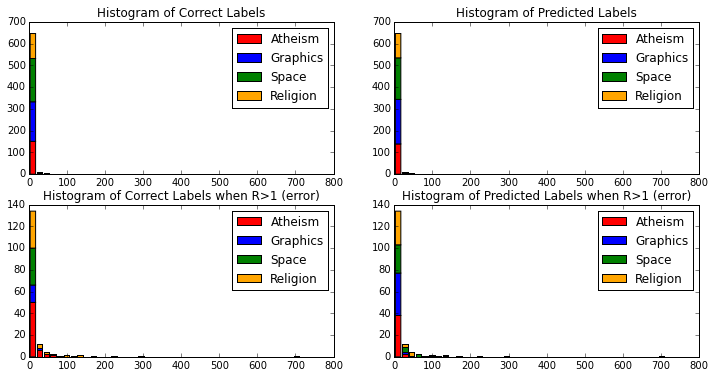

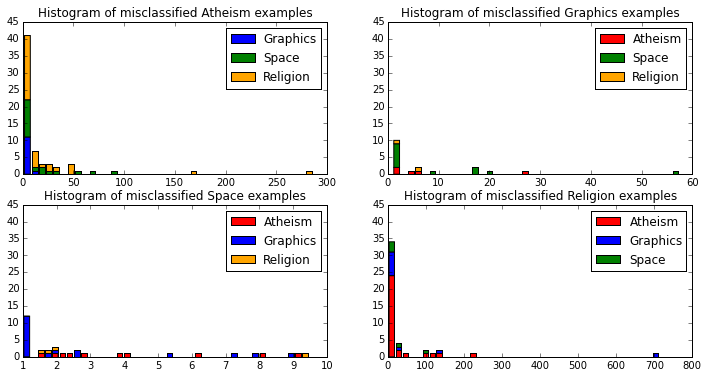

In [16]:
def P8():
### STUDENT START ###
    # Let's try adding some words common in "graphics" (but not exclusive of that topic) as stop_words
    TFIDF = TfidfVectorizer(stop_words=['ftp','site','internet','anonymous','microsoft','online','email','address'])
    feature_vectors_train = TFIDF.fit_transform(raw_documents=train_data)
    Logit_model = LogisticRegression(penalty='l2', C = 100)
    Logit_model.fit(feature_vectors_train, train_labels)
    feature_vectors_dev = TFIDF.transform(raw_documents=dev_data)
    dev_predicted_labels = Logit_model.predict(feature_vectors_dev)
    print 'Accuracy for a Logistic Regression classifier using TfidfVectorizer: {0:.2f}%'.\
        format(100*metrics.accuracy_score(y_true=dev_labels, y_pred=dev_predicted_labels))
    dev_Probs = Logit_model.predict_proba(feature_vectors_dev)
    # maximum predicted probability
    max_Prob = dev_Probs.max(axis=1)
    # predicted probability of the correct label
    Prob_correct_label = np.array([dev_Probs[i,j] for i,j in
                                   zip(range(len(dev_labels)),dev_labels)])
    # R = maximum predicted probability / predicted probability of the correct label
    R = max_Prob / Prob_correct_label
    print 'Percentage of incorrectly predicted labels (R>1): {0:.2f}% (=1-Accuracy)\n'.\
        format(100*len(R[R>1])/float(len(R)))
    # Results from previous Top 3
    for i in (215,665, 607):
        print R[i].round(2), newsgroups_train.target_names[dev_labels[i]].rjust(20),\
            newsgroups_train.target_names[dev_Probs[i,:].argmax()].rjust(20),'\n'
    # Top 3
    doc_index = np.argpartition(R, -3)[-3:]
    # Top 3 in descending order
    doc_index = doc_index[np.argsort(R[doc_index])][::-1]
    for i,ind in enumerate(doc_index):
        print '--------------------------------------------------------'
        print '{0}th DOCUMENT: R = {1:.2f}'.format(ind+1, R[ind])
        print '* PREDICTED CATEGORY (prob = {0:.4f}): {1}'.\
            format(max_Prob[ind],
                   newsgroups_train.target_names[dev_Probs[ind,:].argmax()])
        print '* CORRECT CATEGORY   (prob = {0:.4f}): {1}\n'.\
            format(dev_Probs[ind,dev_labels[ind]],
                   newsgroups_train.target_names[dev_labels[ind]])
        print dev_data[ind]
    
    # Plot histograms of labels (correct and predicted)
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(2, 2, 1)
    atheism = R[(dev_labels==0)]
    graphics = R[(dev_labels==1)]
    space = R[(dev_labels==2)]
    religion = R[(dev_labels==3)]
    plt.hist([atheism,graphics,space,religion], 40, stacked=True, color=['red','blue','green','orange'])
    plt.legend(['Atheism','Graphics','Space','Religion'])
    plt.title('Histogram of Correct Labels')
    ax = plt.subplot(2, 2, 2)
    pred_atheism = R[(dev_predicted_labels==0)]
    pred_graphics = R[(dev_predicted_labels==1)]
    pred_space = R[(dev_predicted_labels==2)]
    pred_religion = R[(dev_predicted_labels==3)]
    plt.hist([pred_atheism,pred_graphics,pred_space,pred_religion], 40,
             stacked=True, color=['red','blue','green','orange'])
    plt.legend(['Atheism','Graphics','Space','Religion'])
    plt.title('Histogram of Predicted Labels')
    # The first two graphs (top row) show all the examples in the dev set
    # The first bar in both graphs show examples with R=1, i.e., correctly classified so the proportion of each
        # category is the same in both graphs (due to the bin width, some examples with an R ratio greater than 1
        # are also included in that first bar, so there may be some minor differences between both graphs)
    # To zoom in what really happens when R>1 (i.e., when the prediction is not correct) we plot (in the bottom row)
        # the histogram for R>1.
    ax = plt.subplot(2, 2, 3)
    atheism = R[(dev_labels==0) & (R>1)]
    graphics = R[(dev_labels==1) & (R>1)]
    space = R[(dev_labels==2) & (R>1)]
    religion = R[(dev_labels==3) & (R>1)]
    plt.hist([atheism,graphics,space,religion], 40, stacked=True, color=['red','blue','green','orange'])
    plt.legend(['Atheism','Graphics','Space','Religion'])
    plt.title('Histogram of Correct Labels when R>1 (error)')
    ax = plt.subplot(2, 2, 4)
    pred_atheism = R[(dev_predicted_labels==0) & (R>1)]
    pred_graphics = R[(dev_predicted_labels==1) & (R>1)]
    pred_space = R[(dev_predicted_labels==2) & (R>1)]
    pred_religion = R[(dev_predicted_labels==3) & (R>1)]
    plt.hist([pred_atheism,pred_graphics,pred_space,pred_religion], 40,
             stacked=True, color=['red','blue','green','orange'])
    plt.legend(['Atheism','Graphics','Space','Religion'])
    plt.title('Histogram of Predicted Labels when R>1 (error)')
    # Roughly same results than before.
        
    # To see what are the most common mistakes, we now plot the proportion of misclassifications for each topic:
    atheism_graphics = R[(dev_labels==0) & (dev_predicted_labels==1)]
    atheism_space = R[(dev_labels==0) & (dev_predicted_labels==2)]
    atheism_religion = R[(dev_labels==0) & (dev_predicted_labels==3)]
    graphics_atheism = R[(dev_labels==1) & (dev_predicted_labels==0)]
    graphics_space = R[(dev_labels==1) & (dev_predicted_labels==2)]
    graphics_religion = R[(dev_labels==1) & (dev_predicted_labels==3)]
    space_atheism = R[(dev_labels==2) & (dev_predicted_labels==0)]
    space_graphics = R[(dev_labels==2) & (dev_predicted_labels==1)]
    space_religion = R[(dev_labels==2) & (dev_predicted_labels==3)]
    religion_atheism = R[(dev_labels==3) & (dev_predicted_labels==0)]
    religion_graphics = R[(dev_labels==3) & (dev_predicted_labels==1)]
    religion_space = R[(dev_labels==3) & (dev_predicted_labels==2)]
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(2, 2, 1)
    plt.hist([atheism_graphics,atheism_space,atheism_religion], 40, stacked=True, color=['blue','green','orange'])
    plt.ylim([0, 45])
    plt.legend(['Graphics','Space','Religion'])
    plt.title('Histogram of misclassified ''Atheism'' examples')
    ax = plt.subplot(2, 2, 2)
    plt.hist([graphics_atheism,graphics_space,graphics_religion], 40, stacked=True, color=['red','green','orange'])
    plt.ylim([0, 45])
    plt.legend(['Atheism','Space','Religion'])
    plt.title('Histogram of misclassified ''Graphics'' examples')
    ax = plt.subplot(2, 2, 3)
    plt.hist([space_atheism,space_graphics,space_religion], 40, stacked=True, color=['red','blue','orange'])
    plt.ylim([0, 45])
    plt.legend(['Atheism','Graphics','Religion'])
    plt.title('Histogram of misclassified ''Space'' examples')
    ax = plt.subplot(2, 2, 4)
    plt.hist([religion_atheism,religion_graphics,religion_space], 40, stacked=True, color=['red','blue','green'])
    plt.ylim([0, 45])
    plt.legend(['Atheism','Graphics','Space'])
    plt.title('Histogram of misclassified ''Religion'' examples')
    # Roughly same results than before.
### STUDENT END ###
P8()

ANSWER: **With that small change, overall accuracy is roughly the same (75.89% vs. 76.33%) and maximum R ratios decrease. Specifically, the R ratio from the previous Top 3 decrease, especially for the 2nd example (from which the *stop_words* come from).**